In [1]:
import torch
import torch.nn as nn
import numpy as np

# 데이터 준비
# 단순 사인 파형으로 데이터를 임의로 설정하였습니다.
data_size = 10000
time_steps = np.linspace(0, 100, data_size, dtype=np.float32)
data_sensor01 = np.sin(time_steps)
data_sensor02 = np.cos(time_steps)
data_light = (data_sensor01 + data_sensor02) / np.sqrt(2)

# PyTorch Tensor로 변환하기 위한 전처리
ndata_s01 = data_sensor01.reshape(data_size, 1)
ndata_s02 = data_sensor02.reshape(data_size, 1)
ndata_light = data_light.reshape(data_size,1)
mdata = np.concatenate((ndata_s01, ndata_s02, ndata_light), axis=1)

# 데이터를 PyTorch Tensor로 변환
mdata = torch.Tensor(mdata)

In [2]:
# 데이터 분할
train_size = int(data_size * 4 / 5)
valid_size = int(data_size / 10)
test_size = int(data_size / 10)

valid_idx = train_size
test_idx = train_size + valid_size

train_data = mdata[:valid_idx]
valid_data = mdata[valid_idx:test_idx]
test_data = mdata[test_idx:]

In [3]:
# LSTM 모델 정의
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)  # 마지막 시간 단계의 출력을 사용
        return out

In [4]:
# 모델 및 손실 함수, 옵티마이저 초기화
input_size = 2  # 입력 데이터의 열 수 (0열과 1열; 센서의 개수)
hidden_size = 64
output_size = 1  # 2열 값(data_light)을 예측
model = LSTM(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [5]:
print(type(train_data))
print(train_data.shape)

<class 'torch.Tensor'>
torch.Size([8000, 3])


In [6]:
# 훈련 루프
num_epochs = 100
for epoch in range(num_epochs):

    inputs = train_data[:, :2].view(1, train_size, input_size)
    targets = train_data[:, 2:].view(1, train_size, output_size)
    outputs = model(inputs)
    optimizer.zero_grad()
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print('훈련 완료!')

Epoch [10/100], Loss: 0.4506
Epoch [20/100], Loss: 0.3352
Epoch [30/100], Loss: 0.0498
Epoch [40/100], Loss: 0.0079
Epoch [50/100], Loss: 0.0119
Epoch [60/100], Loss: 0.0063
Epoch [70/100], Loss: 0.0032
Epoch [80/100], Loss: 0.0020
Epoch [90/100], Loss: 0.0014
Epoch [100/100], Loss: 0.0010
훈련 완료!


In [7]:
# 검증 데이터로 테스트
# 평가 모드로 바꾸고
# inference

In [8]:
# 테스트 데이터로 예측
test_input = test_data[:, :2].view(1, test_size, input_size)
test_predict = model(test_input)

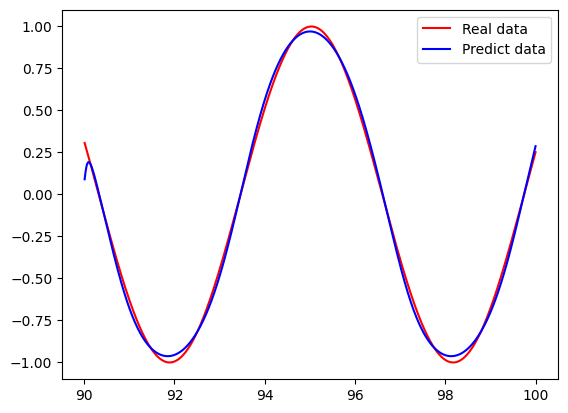

In [9]:
# 테스트 데이터 기반 예측 결과를 시각화
import matplotlib.pyplot as plt

plt.plot(time_steps[test_idx:], ndata_light[test_idx:], 'r', label='Real data')
plt.plot(time_steps[test_idx:], test_predict.detach().numpy()[0], 'b', label='Predict data')
plt.legend()
plt.show()